In [1]:
import pandas as pd
import requests
import zipfile
import io
import os


url = 'https://drive.google.com/uc?export=download&id=16I-dC42IfkCemMtnPfbOkTlxLp14k-Cc'
response = requests.get(url)
response.raise_for_status()  # raise an error if download fails


extract_dir = "Self vs Other"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(extract_dir)

data_frames = {}

for root, dirs, files in os.walk(extract_dir):
    for file_name in files:
        if file_name.endswith(".xlsx"):
            file_path = os.path.join(root, file_name)
            try:
                df = pd.read_excel(file_path)
                data_frames[file_name] = df
                print(f"Loaded: {file_name} with shape {df.shape}")
            except Exception as e:
                print(f"Could not load {file_name}: {e}")

if data_frames:
    first_key = next(iter(data_frames))
    print("\nPreview of first DataFrame:", first_key)
    print(data_frames[first_key].head())


Loaded: parameter_combinations_1.xlsx with shape (6, 5)
Loaded: parameter_combinations_2.xlsx with shape (6, 5)
Loaded: parameter_combinations_3.xlsx with shape (6, 5)
Loaded: parameter_combinations_4.xlsx with shape (6, 5)
Loaded: parameter_combinations_5.xlsx with shape (6, 5)
Loaded: parameter_combinations_6.xlsx with shape (6, 5)
Loaded: parameter_combinations_7.xlsx with shape (6, 5)
Loaded: parameter_combinations_8.xlsx with shape (6, 5)

Preview of first DataFrame: parameter_combinations_1.xlsx
        Noise Type  illusion 1  illusion 2  illusion 3  illusion 4
0  Other_60fps_1px         3.0         2.0         4.0         1.5
1   Self_60fps_1px         4.0         4.0         4.5         3.0
2  Other_60fps_1px         3.0         1.5         2.5         1.5
3   Self_60fps_1px         4.5         4.0         4.0         3.0
4  Other_60fps_1px         3.0         1.5         2.0         1.0


In [2]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15  # You can change the size to fit your needs

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns


# =========================
# CONFIG
# =========================
columns_to_normalize = ['illusion 1', 'illusion 2', 'illusion 3', 'illusion 4']

rename_map = {
    'Self_60fps_1px':  'Self_60fps_1cs',
    'Other_60fps_1px': 'Other_60fps_1cs',
}
valid_noise = ['Self_60fps_1cs', 'Other_60fps_1cs']

# Error bars on bars: 'sd' (standard deviation) OR 'ci' (95% CI)
ERROR_STYLE = 'sd'   # change to 'ci' if you prefer 95% CI whiskers
SHOW_NS = True       # set False to show only significant brackets

display_labels = [
    '1) Iconic trace of\n trajectory',
    '2) Repulsion/\nattraction',
    '3) Action capture\n (visible hand)',
    '4) Action Capture\n (invisible hand)'
]
label_map = dict(zip(columns_to_normalize, display_labels))

# =========================
# 1) Normalize (x−1)/6 within each file (1..7 -> 0..1)
# =========================
for key, df in data_frames.items():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        missing = [c for c in columns_to_normalize if c not in df.columns]
        if missing:
            raise KeyError(f"Missing columns in {key}: {missing}")
        if 'Noise Type' not in df.columns:
            raise KeyError(f"'Noise Type' column missing in {key}")
        data_frames[key][columns_to_normalize] = (df[columns_to_normalize] - 1.0) / 6.0

# =========================
# 2) Per-file means by Noise Type (one row per file×condition)
# =========================
per_file_means = []
for key, df in data_frames.items():
    if key.startswith('parameter_combinations_') and key.endswith('.xlsx'):
        g = df.groupby('Noise Type', as_index=False, observed=True)[columns_to_normalize].mean()
        g['source'] = key
        per_file_means.append(g)

if not per_file_means:
    raise RuntimeError("No matching 'parameter_combinations_*.xlsx' files were found.")

per_source = pd.concat(per_file_means, ignore_index=True)
per_source['Noise Type'] = per_source['Noise Type'].replace(rename_map)
per_source = per_source[per_source['Noise Type'].isin(valid_noise)].copy()

# Keep only sources (files) that have BOTH conditions (paired design)
have_both = (
    per_source.drop_duplicates(['source', 'Noise Type'])
              .groupby('source', observed=True)['Noise Type']
              .nunique()
)
good_sources = have_both.index[have_both == 2]
per_source = per_source[per_source['source'].isin(good_sources)].copy()

per_source['Noise Type'] = pd.Categorical(per_source['Noise Type'],
                                          categories=valid_noise, ordered=True)

# =========================
# 3) Long format for plotting and stats
# =========================
long_df = per_source.melt(
    id_vars=['source', 'Noise Type'],
    value_vars=columns_to_normalize,
    var_name='illusion',
    value_name='value'
)

# =========================
# 4) Paired stats per illusion (paired t-test, Holm correction)
# =========================
from scipy.stats import ttest_rel, wilcoxon, t
from statsmodels.stats.multitest import multipletests

def p_to_stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'

paired_ps = []
paired_records = []

for ill in columns_to_normalize:
    wide = (
        long_df[long_df['illusion'] == ill]
        .pivot_table(index='source', columns='Noise Type', values='value', observed=True)

    )
    wide = wide.dropna(subset=valid_noise)  # ensure both present
    x = wide['Self_60fps_1cs'].to_numpy()
    y = wide['Other_60fps_1cs'].to_numpy()

    if len(x) >= 2 and len(y) >= 2:
        # If vectors are identical or constant, skip t-test to avoid NaNs
        if np.allclose(x, y, equal_nan=True) or (np.nanstd(x, ddof=1) == 0 and np.nanstd(y, ddof=1) == 0):
            p = 1.0
        else:
            tstat, p = ttest_rel(x, y, nan_policy='omit')
            if not np.isfinite(p):
                p = 1.0
    else:
        # Fallback to Wilcoxon if possible, else n.s.
        try:
            if len(x) >= 1 and len(y) >= 1:
                _, p = wilcoxon(x, y, alternative='two-sided')
            else:
                p = 1.0
        except Exception:
            p = 1.0

    paired_ps.append(p)
    paired_records.append({'illusion': ill, 'p_raw': float(p)})

# Holm correction across the 4 illusions
reject, p_adj, _, _ = multipletests(paired_ps, alpha=0.05, method='holm')

comparisons_by_illusion = {}
for rec, r, pa in zip(paired_records, reject, p_adj):
    ill = rec['illusion']
    comparisons_by_illusion[ill] = pd.DataFrame([{
        'group1': 'Self_60fps_1cs',
        'group2': 'Other_60fps_1cs',
        'p_raw': float(rec['p_raw']),
        'p_adj': float(pa),
        'reject': bool(r),
        'stars': p_to_stars(float(pa)),
    }])

# =========================
# 5) Summary (means/SD across files) + (optional) CI half-widths
# =========================
summary = (
    per_source
    .groupby('Noise Type', observed=True)[columns_to_normalize]
    .agg(['mean', 'std', 'count'])
)
summary.columns = [' '.join(t).strip() for t in summary.columns.to_flat_index()]
summary = summary.reset_index()

def ci_halfwidth(group_values, alpha=0.05):
    """95% CI half-width for the mean of a sample."""
    vals = np.asarray(group_values, dtype=float)
    vals = vals[~np.isnan(vals)]
    n = len(vals)
    if n < 2:
        return 0.0
    s = np.nanstd(vals, ddof=1)
    return float(t.ppf(1 - alpha/2, n-1) * s / np.sqrt(n))

# Precompute CI half-widths per group×illusion if needed
ci_hw = {}  # dict: (noise, illusion) -> halfwidth
if ERROR_STYLE.lower() == 'ci':
    for g in valid_noise:
        for ill in columns_to_normalize:
            vals = per_source.loc[per_source['Noise Type'] == g, ill]
            ci_hw[(g, ill)] = ci_halfwidth(vals)




C:\Users\Jayden\AppData\Local\Temp\ipykernel_16072\593795852.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2.0}` instead.

  sns.barplot(


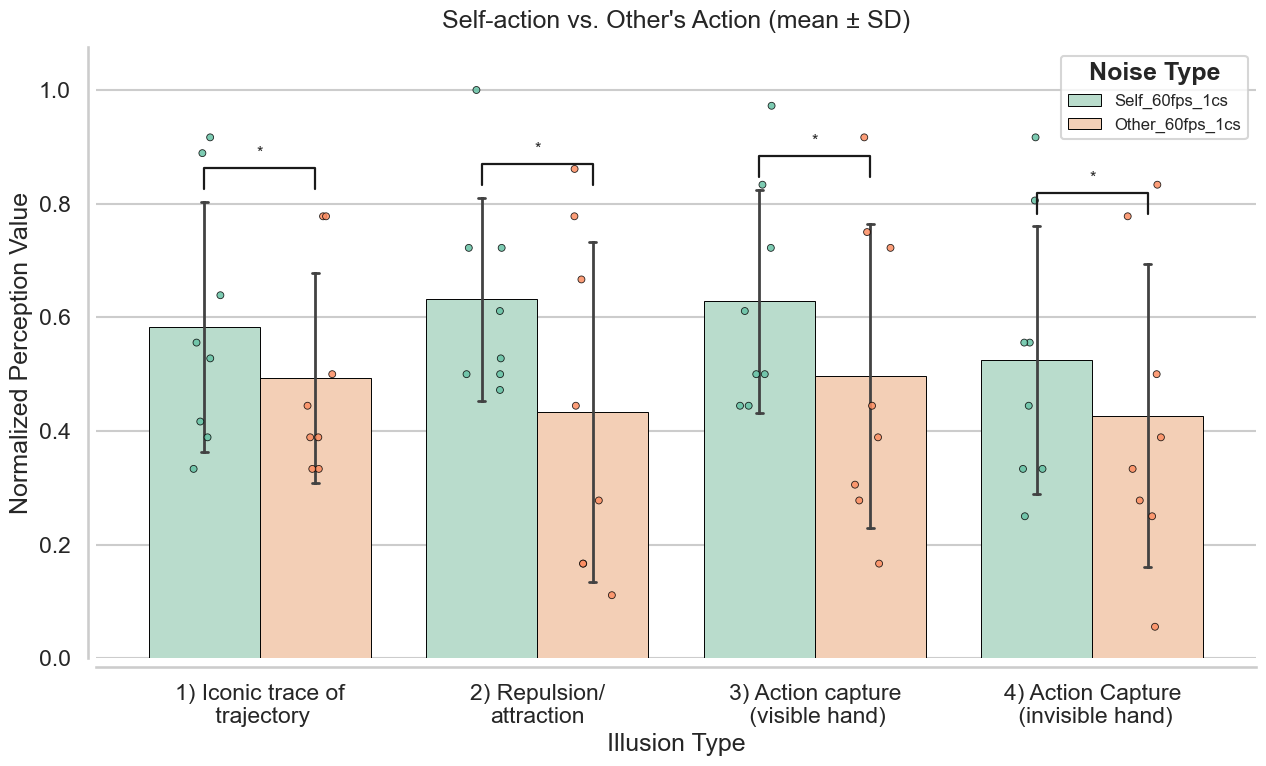

In [4]:
# =========================
# 6) Plot (grouped bars + per-file points + significance)
# =========================
sns.set_theme(style="whitegrid", context="talk")
bar_palette   = sns.color_palette("Pastel2", n_colors=len(valid_noise))
point_palette = sns.color_palette("Set2",    n_colors=len(valid_noise))

fig, ax = plt.subplots(figsize=(13, 8))

# Bars (Seaborn computes mean + chosen error bars from long_df)
if ERROR_STYLE.lower() == 'sd':
    err = 'sd'
elif ERROR_STYLE.lower() == 'ci':
    err = ('ci', 95)
else:
    err = 'sd'
 

sns.barplot(
    data=long_df,
    x="illusion", y="value",
    hue="Noise Type",
    order=columns_to_normalize,
    hue_order=valid_noise,
    errorbar=err,
    capsize=0.05,
    errwidth=2.0,
    edgecolor="black", linewidth=0.7,
    palette=bar_palette,
    ax=ax
)

# Overlay per-file replicates
sns.stripplot(
    data=long_df,
    x="illusion", y="value",
    hue="Noise Type",
    order=columns_to_normalize, hue_order=valid_noise,
    dodge=True, jitter=0.15,
    alpha=0.85, size=5,
    linewidth=0.6, edgecolor="black",
    palette=point_palette,
    ax=ax, legend=False
)

# Labels / legend
ax.set_title("Self-action vs. Other's Action (mean ± SD)", fontsize=18, pad=14)


ax.set_xlabel("Illusion Type")
ax.set_ylabel("Normalized Perception Value")
xticks = np.arange(len(columns_to_normalize))
ax.set_xticks(xticks, labels=[label_map[ill] for ill in columns_to_normalize], rotation=0)
sns.despine(ax=ax, offset=6)

leg = ax.legend(title="Noise Type", loc="upper right", frameon=True, fontsize=12)
leg.get_title().set_weight("bold")

# --------- Significance brackets ---------
# Geometry (match seaborn categorical spacing)
x_positions = np.arange(len(columns_to_normalize))
hue_to_index = {g: i for i, g in enumerate(valid_noise)}
n_hue = len(valid_noise)
bar_cluster_width = 0.8
per_hue_offset   = bar_cluster_width / n_hue

def xcoord(ill_idx, group_name):
    j = hue_to_index[group_name]
    return x_positions[ill_idx] + (j - (n_hue - 1) / 2) * per_hue_offset

def add_bracket(ax, x1, x2, y, text, height, yrange):
    ax.plot([x1, x1, x2, x2],
            [y, y + height, y + height, y],
            lw=1.6, c='k', clip_on=False, zorder=30)
    ax.text((x1 + x2)/2, y + height + 0.012*yrange, text,
            ha='center', va='bottom', fontsize=12, zorder=31)

# Headroom for brackets based on chosen error style
top_envelope = []
for ill in columns_to_normalize:
    for g in valid_noise:
        mu = float(summary.loc[summary['Noise Type'] == g, f'{ill} mean'].values[0])
        if ERROR_STYLE.lower() == 'ci':
            hw = ci_hw.get((g, ill), 0.0)
        else:
            sd = summary.loc[summary['Noise Type'] == g, f'{ill} std'].values[0]
            hw = float(sd) if np.isfinite(sd) else 0.0
        top_envelope.append(mu + hw)

ax.set_ylim(0, max(1.05, (max(top_envelope) if top_envelope else 0.9) + 0.25))

ymin, ymax = ax.get_ylim()
yrange = ymax - ymin
BRACKET_H = 0.035 * yrange

# Draw one comparison per illusion: Self vs Other
for i, ill in enumerate(columns_to_normalize):
    # baseline above tallest bar (mean + error) for this illusion
    y_candidates = []
    for g in valid_noise:
        mu = float(summary.loc[summary['Noise Type'] == g, f'{ill} mean'].values[0])
        if ERROR_STYLE.lower() == 'ci':
            hw = ci_hw.get((g, ill), 0.0)
        else:
            sd = summary.loc[summary['Noise Type'] == g, f'{ill} std'].values[0]
            hw = float(sd) if np.isfinite(sd) else 0.0
        y_candidates.append(mu + hw)
    base_y = (max(y_candidates) if y_candidates else 0.9) + 0.02 * yrange

    rec = comparisons_by_illusion.get(ill)
    if rec is None or rec.empty:
        continue
    stars = str(rec.iloc[0]['stars'])
    if (stars != 'n.s.') or SHOW_NS:
        x1 = xcoord(i, 'Self_60fps_1cs')
        x2 = xcoord(i, 'Other_60fps_1cs')
        add_bracket(ax, x1, x2, base_y, stars, BRACKET_H, yrange)

plt.tight_layout()
plt.savefig("./Self_vs_Other.svg", bbox_inches="tight")
plt.show()